In [6]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import arviz as az
import theano.tensor as tt

import warnings
warnings.filterwarnings("ignore")

# Get Data

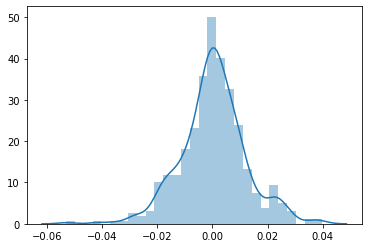

In [83]:
data = np.load("sample_data/fgs.npy" , allow_pickle = True).item()


# Combine Seperate DFs into one
ret_df = pd.DataFrame()
for k , v in data.items():
    # Create Returns and Directional Movement
    v.sort_index(ascending = True, inplace = True)
    v["ret"] = v["close"].pct_change()
    v.dropna(axis = 0 , inplace = True)
    v["dir"] = v["ret"].apply(lambda x: 1 if x >= 0  else 0)
    v["prod"] = k
    ret_df = pd.concat([ret_df , v["ret"]] , axis = 1)

# Mix F and G together see if can be recovered
ret_df.columns = data.keys()
ret_arr = ret_df[["F","G"]].values.ravel()
sns.distplot(ret_arr)

# Normal Mixture Model with Dirichlet
## !!! Chains did not converge

In [81]:
cluster = 2
with pm.Model() as model_mgp:
    p = pm.Dirichlet('p', a=np.ones(cluster))
    means = pm.Normal('means',
                      mu=np.linspace(ret_arr.min(), ret_arr.max(), cluster),
                      sd=10, shape=cluster,
                      transform=pm.distributions.transforms.ordered)
    sd = pm.HalfNormal('sd', sd=10)
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd,  observed=ret_arr)
    trace_mgp = pm.sample(1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, means, p]
Sampling 2 chains, 30 divergences: 100%|██████████| 3000/3000 [01:18<00:00, 38.21draws/s] 
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9418281514237395, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p[0],0.456,0.446,0.004,1.000,0.269,0.215,3.0,3.0,3.0,28.0,1.80
p[1],0.544,0.446,0.000,0.996,0.269,0.219,3.0,3.0,3.0,28.0,1.80
means[0],-0.016,0.019,-0.049,0.002,0.011,0.008,3.0,3.0,3.0,30.0,1.68
means[1],1.876,4.517,-0.001,11.150,1.981,1.488,5.0,5.0,3.0,25.0,1.64
sd,0.012,0.001,0.011,0.013,0.000,0.000,51.0,47.0,44.0,261.0,1.07


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x128f1a3d0>,
      dtype=object)

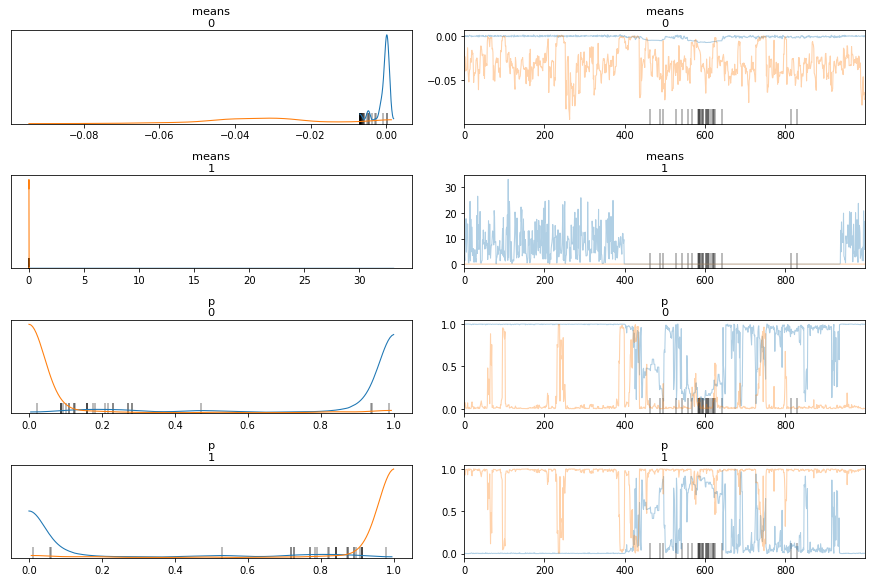

In [82]:
varnames = ['means', 'p']
display(az.summary(trace_mgp))
az.plot_trace(trace_mgp, varnames)